# Bayesian linear regression

## Example 1. Simple univariate regression - real-estate price prediction

Consider an example of predicting prices of individual homes $y$ vs their sizes $x$:
$$
y=w x+\varepsilon,
$$
given a series of single-dimensional observations $D=\{(y_i,x_i), i=1..N\}$, where $w$ is the slope coefficient to fit (in our case - average price of the square foot) and $\epsilon$ is the error term (deviation of the specific price from the predicted value), assuming that 
$$
\varepsilon\sim {\cal N}(0,\sigma^2).
$$
As we remember ordinary least square (OLS) estimate in the univariate case gives a simple estimate $\hat{w}$ for the slope coefficient $w$:
$$
\hat{w}=\frac{\sum_i y_i x_i}{\sum_i x_i^2}.
$$
After we get $w=\hat{w}$ it is easy to estimate the standard error 
$$
\sigma=\sqrt{\frac{\sum_i (y_i-\hat{w} x_i)^2}{N}}.
$$

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.io.data as web
import Quandl
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pymc3 as pm
from numpy import random
import random as rnd
from scipy import stats
from pandas.stats.api import ols
import pylab
from sklearn import linear_model
plt.rcParams["figure.figsize"]=(10.0,8.0)

Populating the interactive namespace from numpy and matplotlib


/Users/Dexter/anaconda/lib/python2.7/site-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [3]:
#read real estate sample data
REsample1 = pd.read_csv('data/REsample1.csv')
REsample1.head()

,Unnamed: 0,borough,neighborhood,building_class_category,tax_class_present,block,lot,easement,building_class_present,address,...,land_sq_feet,gross_sq_feet,year_built,tax_class_time_sale,build_class_time_sale,sale_price,sale_date,serialid,sale_year,sale_month
0,5631,3,BAY RIDGE,01 ONE FAMILY HOMES,1,5871,91,NaN,A5,24 BAY RIDGE PLACE,...,1600,1400,1910,1,A5,585000,2009-10-29,5631,9,9
1,5635,3,BAY RIDGE,01 ONE FAMILY HOMES,1,5882,38,NaN,A5,7014 LOUISE TERRACE,...,1169,1224,1925,1,A5,515000,2009-10-15,5635,9,9
2,5636,3,BAY RIDGE,01 ONE FAMILY HOMES,1,5882,50,NaN,A5,7009 LOUISE TERRACE,...,945,1836,1925,1,A5,499900,2009-04-20,5636,9,3
3,5637,3,BAY RIDGE,01 ONE FAMILY HOMES,1,5882,80,NaN,A5,7002 COLONIAL ROAD,...,1121,1330,1925,1,A5,525000,2009-09-02,5637,9,8
4,5638,3,BAY RIDGE,01 ONE FAMILY HOMES,1,5882,81,NaN,A5,7004 COLONIAL ROAD,...,1118,1224,1925,1,A5,400000,2009-07-24,5638,9,6


In [4]:
#first fit the regression for the entire sample
RE1w=sum(REsample1.sale_price*REsample1.gross_sq_feet)/sum(REsample1.gross_sq_feet**2)
#estimate the standard error sigma
sigma=std(REsample1.sale_price-REsample1.gross_sq_feet*RE1w)
print('Estimated w={0}, sigma={1}'.format(RE1w,sigma))

Estimated w=423.262774919, sigma=387363.577755


In [5]:
#now redo the regression for just the first 100 records
REsample11=REsample1.loc[0:99]
RE11w=sum(REsample11.sale_price*REsample11.gross_sq_feet)/sum(REsample11.gross_sq_feet**2)
print('Estimated w={0}'.format(RE11w))

Estimated w=369.713904612


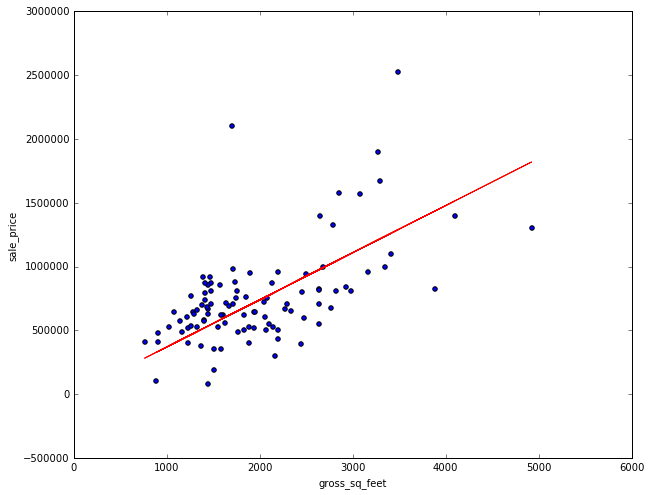

In [6]:
#visualize the fit
REsample11.plot(kind='scatter',x='gross_sq_feet',y='sale_price')
y1=RE11w*REsample11.gross_sq_feet
plt.plot(REsample11.gross_sq_feet,y1,'r-')

We see quite a deviation in the estimates $\hat{w}$ obtained - so the OLS estimate depends on the sample choice and uses to vary from one sample to another. So for any particular choice of the training sample there is no guarantee that the estimate $\hat{w}$ is indeed a true value for $w$ - we should admit uncertainty in our estimate, which OLS does not really allow to make, but the further Bayesian framework will.

# Bayesian univariate regression

Also imagine that we already have certain prior knowledge about $w$ for example this would be the case if we already studied some sample of house prices before. Can we take this into account somehow? The prior knowledge can be expressed through a prior distribution $p(w)$.

Consider a probabilistic version of a univariate regression:
$$
y\sim {\cal N}(w x,\sigma^2),
$$
assuming that the variance $\sigma^2$ is given or at least independent on $w$ and the only real-valued single dimensional coefficient to estimate based on a series of single-dimensional observations $D=(Y,X)=\{(y_i,x_i), i=1..N\}$ is $w$. In a similar manner as we just did for fitting a normal distribution, each single observation changes a given conjugate normal prior
$$
w\sim {\cal N}(w^*,\sigma^*)
$$
to a posterior
$$
p(w|y=y_i, x=x_i)\sim p(y=y_i|w,x=x_i)p(w)\sim e^{-\frac{(y_i-w x_i)^2}{2\sigma^2}-\frac{(w-w^*)^2}{2(\sigma^*)^2}}\sim
$$$$
\sim e^{-w^2 \frac{x_i^2(\sigma^*)^2+\sigma^2}{2\sigma^2(\sigma^*)^2}+w \frac{(\sigma^*)^2 y_i x_i+\sigma^2 w^*}{2\sigma^2(\sigma^*)^2}}
\sim e^{\frac{\left(w-\frac{ \sigma^{-2} y_i x_i +(\sigma^*)^{-2} w^*}{ \left(x_i^2\sigma^{-2}+(\sigma^*)^{-2}\right)}\right)^2}{\frac{2 }{(\sigma^*)^{-2}+x_i^2\sigma^{-2}}}}
$$
so posterior distribution is also normal.


In order to add all the observations from $D$ one can either inerate the above process or consider a single equation based on a multi-variable probability distribution, which is easy to handle assuming that different observations are independent:
$$
p(w|Y, X)\sim p(Y|w,X)p(w)=p(w)\prod\limits_i p(y=y_i|w,x=x_i)\sim e^{-\sum\limits_i \frac{(y_i-w x_i)^2}{2\sigma^2}-\frac{(w-w^*)^2}{2(\sigma^*)^2}}=e^{-\frac{RSS(w)}{2\sigma^2}-\frac{(w-w^*)^2}{2(\sigma^*)^2}}\hspace{5ex} (1)
$$
If one needs a specific estimate $\hat{w}$ for $w$ then it could be found as the most probable value from
$$
\hat{w}=argmax_w p(w|Y, X)=argmin_w\left[\frac{RSS(w)}{2\sigma^2}+\frac{(w-w^*)^2}{2(\sigma^*)^2}\right]\hspace{5ex} (2)
$$

$$
p(w|Y, X)\sim e^{-w^2 \frac{\sum_i x_i^2(\sigma^*)^2+\sigma^2}{2\sigma^2(\sigma^*)^2}+w \frac{(\sigma^*)^2 \sum_i y_i x_i+\sigma^2 w^*}{2\sigma^2(\sigma^*)^2}}\sim e^{\frac{\left(w-\frac{ \sigma^{-2} \sum_i y_i x_i +(\sigma^*)^{-2} w^*}{\left(\sum_i x_i^2\sigma^{-2}+(\sigma^*)^{-2}\right)}\right)^2}{\frac{2}{(\sigma^*)^{-2}+\sum_i x_i^2\sigma^{-2}}}}\sim
$$

$$
\sim {\cal N}\left(\frac{ \sigma^{-2} \sum_i y_i x_i +(\sigma^*)^{-2} w^*}{\left(\sum_i x_i^2\sigma^{-2}+(\sigma^*)^{-2}\right)},
\frac{1}{\sqrt{(\sigma^*)^{-2}+\sum_i x_i^2\sigma^{-2}}}\right)
$$

### Uninformed prior

In case of an unfinformed prior with $\sigma^*\to \infty$ the above estimate (2) is tends to be equivalent to the one given by the regular OLS, i.e. to
$$
RSS(w)\to \min
$$
However in addition to the single best fit slope coefficient estimate (2), Bayesian regression also provides an entire probabilistic normal distribution
$$
w\sim {\cal N}\left(\frac{\sum_i x_i y_i}{\sum_i x_i^2},\frac{\sigma}{\sqrt{\sum_i x_i^2}}\right)
$$
for the possible values of $w$, being able to explain from the rigorous probabilistic standpoint the meaning behind the confidence intervals and hypothesis testing.

One point here is that so far we consider $\sigma$ as given. There is a more sophisticated Bayesian framework which allows to estimate it together with $w$ (conceptually just enough to consider a vector of two latent variables $w,\sigma$ instead of $w$ and specify its joint prior distribution, although maths is much heavier in that case). For now we can simply rely on the streightforward max-likelihood estimate
$$
\hat{\sigma}^2=\frac{RSS(\hat{w})}{N}
$$
also being an actual sample standard deviation of the set of observed prediction errors for the optimal $w=\hat{w}$.

## Example 1 revisited. Distribution for the sq.foot price

In [6]:
#we just need to select sigma here - take the one we estimated for the entire sample
RE11s=sigma/(sum(REsample11.gross_sq_feet**2)**0.5)

In [7]:
print('w ~ N({0},{1})'.format(RE11w,RE11s))

w ~ N(369.713904612,18.293523802)


notice that the standard deviation we found for $w$ depends on the choice of $\sigma$ and might become different if we take $\sigma$ based on the considered subsample rather than the entire sample as we did.

## Example 2. Bayesian regression example - tuning the houses price regression trained above

Now if say we have the results of the previos estimate (but not retain the training data anymore) and later find more training data to consider, we can further adjust the former estimate through the above Bayesian framework.

In [8]:
#consider the remaining part of the housing prices data separately
REsample12=REsample1.loc[100:]
#and compute the OLS estimate
RE12w0=sum(REsample12.sale_price*REsample12.gross_sq_feet)/sum(REsample12.gross_sq_feet**2)
print('Estimated w={0}'.format(RE12w0))

Estimated w=450.921318897


In [9]:
#now implement Bayesian regression starting from the prior obtained based on the first sample w ~ N(369.713904612,18.293523802)
RE12w0=sum(REsample12.sale_price*REsample12.gross_sq_feet)/sum(REsample12.gross_sq_feet**2)
s22=sigma**-2; s12=RE11s**-2
RE12w=(s22*sum(REsample12.sale_price*REsample12.gross_sq_feet)+s12*RE11w)/(s22*sum(REsample12.gross_sq_feet**2)+s12)
RE12s=(s22*sum(REsample12.gross_sq_feet**2)+s12)**(-0.5)
print('w ~ N({0},{1})'.format(RE12w,RE12s))

w ~ N(423.262774919,10.6761381647)


This is already pretty consistend with what python will give us if we take the entire training sample at once

In [10]:
lm = smf.ols(formula='sale_price ~ gross_sq_feet -1', data = REsample1).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     1562.
Date:                Mon, 01 Feb 2016   Prob (F-statistic):          1.13e-122
Time:                        23:30:24   Log-Likelihood:                -4414.8
No. Observations:                 309   AIC:                             8832.
Df Residuals:                     308   BIC:                             8835.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
gross_sq_feet   423.2628     10.708     39.528

So Bayesian framework allows to efficiently utilize prior knowledge on the regression parameters to be estimated and also provides us not just with one single best estimate for them but with the entire distribution for the possible value, admitting uncertainty. 

Let's also give some intuition of how strongly the prior knowledge affects the result compared to the new knowledge obtained from the training sample. Clearly if the prior knowledge is obtained from just a few observations while the further sample considered is pretty big, the result should be dominated by the further observations with little impact of the prior. But it seems that there is no information about how big the initial sample was... However this is not actually the case! 

The key here is the deviation we have in the prior distribution - the fewer data was used to generate the prior estimate, the more uncertain it will be (higher deviation) and the smaller will be its impact on the posterior. For example uninformed prior having variance going to infinity, tends to have no impact on the result. On the other hand, a very narrow prior means that it has been obtained based on a very strong evidence and should have a major impact on the posterior despite further observations. So all necessary information is already in the prior - when we combine prior estimate based on one sample and with the further observations from the second sample, the first sample size is somehow "encoded" in the prior variance and all the necessary information is already there.

# Multivariate case and regularization

Now consider a multivatiate linear regression model
$$
y\sim {\cal N}(w^T x,\sigma^2).
$$
Again assume that $\sigma$ is known or independent on $w$, while for the components of the vector $w=(w_1,w_2,...w_n)$ the prior distributions are known to be pairwise independent normal distributions
$$
w_j\sim{\cal N}(w_j^*,\sigma_j^*).
$$

$$
p(w|Y,X)\sim p(Y|w,X)p(w)=p(w)\prod\limits_i p(y=y_i|w,x=x_i)p(w)=\prod_i p(y=y_i|w,x=x_i)\prod_j p(w_j)\sim 
$$
$$
\sim\prod\limits_i e^{\frac{-(y_i-w^T x_i)^2}{2\sigma^2}}\prod\limits_j e^{-\frac{(w_j-w_j^*)^2}{2(\sigma_i^*)^2}}=e^{-\frac{RSS(w)}{2\sigma^2}-\sum\limits_j \frac{(w_j-w_j^*)^2}{2(\sigma_i^*)^2}},
$$

so the estimate for the best fit $\hat{w}$ could be found from
$$
\hat{w}=argmax_w p(w|Y, X)=argmin_w\left[\frac{RSS(w)}{\sigma^2}+\sum\limits_j\frac{(w_j-w_j^*)^2}{(\sigma_j^*)^2}\right]\hspace{5ex}
$$

An important particular case of all the components of $w$ having the same prior $w_j\sim{\cal N}(0,\sigma/\sqrt{\lambda})$ leads to

$$
\hat{w}=argmin_w\left[RSS(w)+\lambda||w||_2^2\right]\hspace{5ex}(3)
$$

where $||w||_2=\sqrt{\sum\limits_j w_j^2}$, known as Ridge regression.

An alternative choice of the Laplacian prior distribution $p(w_j)\sim e^{-\lambda|w_j|/\sigma}$ leads to  
$$
\hat{w}=argmin_w\left[RSS(w)+\lambda||w||_1\right],\hspace{5ex}(4)
$$
where $||w||_1=\sum\limits_j |w_j|$, known as Lasso (least absolute shrinkage and selection operator) regression.

Both Ridge and Lasso could be shown to be equivalent to a constrained minimization of $RSS$:

$$
RSS(w)\to min, \ ||w||_p\leq \alpha,\hspace{5ex}(5)
$$

with $p=1,2$ respectively, although analytic relation between constants $\alpha$ and $\lambda$ is somewhat nontrivial. In practice however the choice of $\lambda$ or $\alpha$ is usually empirical anyway, so both regularized (i.e. (3)-(4) with adding a regularization term ||w||) or constrained forms (5) of the optimization problem are equally applicable.

Optimization problems (3) and (4) tend to minimize $RSS$ at the same time penalizing the regression for having $||w||$ too large (regularization) which often leads to the model complexity through multiple regressors with large coefficients canceling effect of each other. So in a sense Lasso and Ridge are trying to avoid this situation, looking for relatively simple "regular" models with best possible fit. 

Their Bayesian derivation show that Lasso and Ridge simply perform the regression with the prior belief that all the components of the $w$ are limited through the fixed variance of the priors. Such a belief affects the final outcome of the model making solutions with large $||w||$ to be particularly unlikely.

This helps Ridge and Lasso to fight overfitting also dealing with multicollinearity of regressors to some extent, preventing from learning noise through particularly complex "unnatural" combinations of the regressors.

Ridge regression admits solution in the closed form (consider partial derivatives of the objective function with respect to $w_j$):

$$
\hat{w}=(X^T X+\lambda I)^{-1}X^T Y, \hspace{5ex} (6)
$$

where $I$ is the identity $n\times n$ matrix, while $n$ being the number of regressors. The formulae (6) shows that the Ridge regression can in theory deal with the case of multicollinearity, when the matrix $X^T X$ is singular and OLS estimate does not exist.

Lasso does not admit solution in the closed form and requires numerical methods (like subgradient methods) to be fit. 
Lasso however has an advantage of being able to completely eliminate impact of certain irrelevant regressors setting the corresponding slope coefficients to zero.  

# Bias-variance trade-off

Suppose that the data considered have been indeed generated by a certain "true" model
$$
y\sim {\cal N}(w^T x,\sigma^2),
$$
while "true" $w$ is not known to us and is being approximated by our estimates $\hat{w}$ picked up from the posterior distribution given by our model (e.g. OLS, Ridge, Lasso etc).

The ability of the model to predict future values of $y$ for specific $x$ can be expressed as (using $E[X^2]=E[X]^2+Var[X]$ and $E[y]=E[w^T x]$):

$$
E\left[(y-\hat{w}^T x)^2\right]=Bias[\hat{w}^T x]^2+Var[\hat{w}^T x]^2+\sigma^2,
$$

where for each specific $x$
$$
{\rm Bias}[\hat{w}^T x]=(E[\hat{w}^T x]-w^T x) 
$$
shows how shifted on average will our prediction be vs the unknown "true" model prediction, while
$$
Var[\hat{w}^T x]=E[(\hat{w}^T x-E[\hat{w}^T x])^2]
$$
shows how uncertain is our prediction given the variation of the estimate $\hat{w}$. The third term $\sigma^2$ corresponds to an irreducible error, caused by the noise in the data generation process.

So the ability of the model to predict future values of $y$ depends (besides the irreducible error which we're not in control of) on both - the variance in our estimae of $\hat{w}$ as well as the bias in our estimation (i.e. systematic shift like under or overestimation) of the true values of $w$ and $y$. 

The OLS estimate in theory is known to be unbiased (tends to have zero bias provided that the training sample is large enough), however might have pretty high variance in $\hat{w}$ especially when the regressors are highly correlated. This reduces its generalizeability. Regularized regression, like Ridge and Lasso can introduce some bias (might not fit the training sample that well), but may largely reduce variance by limiting the $||w||$ (and become much less sensitive to small changes in the training data, reducing the risk of overfitting).

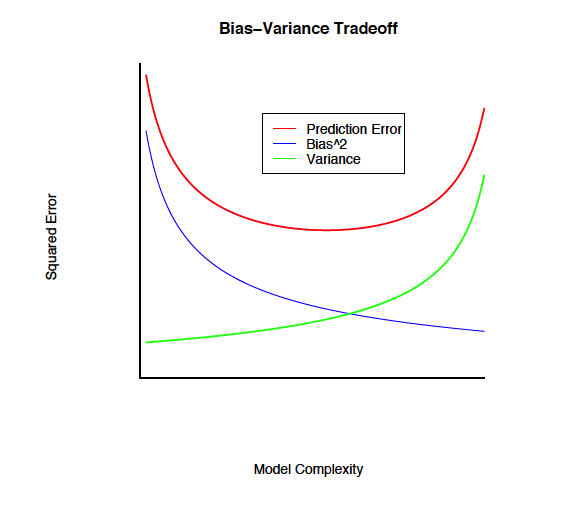

In [11]:
from IPython.display import Image
Image(filename='data/biasvariance.png') 

Generally, often the more complex model able to better learn from the training sample (lower bias) have higher variance, which leads to overfitting and high error for predicting the future values of the output variable.

### Validation and cross-validation

A good way to validate the model is to use a test set separate from the training sample to evaluate the model performance. Additionally if the model depends on the certain parameters (like $\alpha,\lambda$ for Lasso/Ridge) which are not supposed to be fit during the training phase, a separate validation sample could be used for the selection of model parameters (we pick up those which optimize model performance over the validation set). Usually test and validation sets are got as subsamples (often random) of the available dataset, while the remaining data is used as the training sample. 

But often the available dataset is small enough, so splitting into into even smaller traning, validation and test sets could have negative impact on the model training leading to noisy and unreliable models. In such cases cross-validation is often applied, performing not one but several random splits of the sample with further averaging of the model performance scores. 

## Choice of $\lambda$ or $\alpha$. Model validation.

In both - constrained and regularized forms - the parameter $\alpha$ or $\lambda$ of Lasso/Ridge regression is somewhat arbitrary and can take any value from $0$ to $+\infty$. Small values of $\lambda$ or high values of $\alpha$ lead to the result close to OLS (identical to it is $\lambda=0$ or $\alpha=+\infty$), while large $\lambda$ or small $\alpha$ tend to overemphasize the impact of regularization over the fit itself. There is no single best way of choosing the value of the regularization parameter - what is usually suggested is to fit it by evaluating the model for different values of the parameter over the separate validation set and picking up the value for which the validation performance is the best one. As for the performance metric one can use RSS or, equivalently, R2.

## Example 3. Regularization with artifical data

In [7]:
#Upload the data
data3=pd.read_csv("data/example3.csv") # load the data 
y=np.asarray(data3.iloc[:,-1]) # make dependent variable
X=np.asarray(data3.iloc[:,0:-1]) #make independent variables

In [8]:
print(len(data3))
data3.head()

50


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,Y
0,26,22.415927,1.481339,9.634145,-15.316976,3.707672,44.960785,27.480018,48.835505,5.382629,...,42.863416,39,26,95,83,16,21,66,87,17.023843
1,68,59.433665,14.979972,22.192560,-35.872848,12.682355,117.701114,66.681792,124.983058,18.150923,...,101.877161,45,52,24,42,97,65,47,94,73.075316
2,45,39.162046,7.587863,15.315333,-24.616061,7.767647,77.867124,45.214154,83.283207,11.158762,...,69.560110,53,64,31,31,64,74,19,55,34.872741
3,91,79.705283,22.372081,29.069787,-47.129635,17.597062,157.535104,88.149430,166.682908,25.143084,...,134.194211,90,50,49,30,95,65,80,77,64.479635
4,15,12.720805,-2.054018,6.345036,-9.933295,1.357160,25.909746,17.212886,28.892098,2.038551,...,27.407435,9,49,73,23,76,37,44,55,19.937208


In [9]:
#Let's have a quick look of the OLS for whole data
result=ols(y=y,x=pd.DataFrame(X))
# You will see NaN values becuase the number is too small or too big to calculate here. We do not need to care about it
#since we only care about prediction. The coeffiencts might be unreliable due to the collinearity. 
result.summary_as_matrix.T

,beta,p-value,std err,t-stat
0,3.757231e+08,NaN,NaN,NaN
1,-7.496352e+07,NaN,NaN,NaN
2,9.353953e+08,NaN,NaN,NaN
3,2.537093e+09,NaN,NaN,NaN
4,-4.952650e+08,NaN,NaN,NaN
5,8.663074e+08,NaN,NaN,NaN
6,1.194379e+08,NaN,NaN,NaN
7,-5.983284e+08,NaN,NaN,NaN
8,1.651503e+07,NaN,NaN,NaN
9,-2.162900e+09,NaN,NaN,NaN


Let's evaluate if this OLS model for such a dataset is actually generalizeable. For that purpose let us divide the dataset into training set and the test set.

In [10]:
train_index=[22,15,31,18,34,32,12,26,19,0,44,5,41,4,2,21,11,28,14,46,8,25,20,33,35,39,10,27,7,42]
test_index=[x for x in list(range(len(X))) if x not in train_index]
#Generate data for training and testing.
X_train=X[train_index,:] #training variables
y_train=y[train_index] #training dependent variables
X_test=X[test_index,:] #prediction variables
y_test=y[test_index] #prediction dependent variable
print('Size of the training set={0}, test set={1}').format(len(train_index),len(test_index))

Size of the training set=30, test set=20


In [16]:
# In the sample. (Only use training set)
result=ols(y=y_train,x=pd.DataFrame(X_train))
#print(result.summary_as_matrix.T)
R_2_IS=result.r2  # get R2
OLS_coef=result.beta

#Out of sample 
a=np.array(X_test)  #makes sure conver pd data to np array
b=np.array(result.beta) #makes sure conver pd data to np array
print('OLS regression coefficients={0}'.format(b))
c=np.sum(a*b[0:-1],axis=1)+b[-1] #b is estimated coefficients, a is prediction data, b[-1] is intercept. This is for predicted y
error=y_test-c # y_predict is real value, c is the value we guessed
R_2_OS=1-error.var()/y_test.var() # this is out of sample R2
print("The R-squared we found for in-sample (IS) OLS is: {0}".format(R_2_IS))
print("The R-squared we found for out-of-sample (OS) OLS is: {0}".format(R_2_OS))

OLS regression coefficients=[  2.96536426e+10   1.44001991e+10  -2.31281699e+10  -9.13020363e+09
  -1.41158081e+10   1.15295408e+10   1.30825936e+09  -5.53322155e+09
  -1.42820790e+09  -4.91641257e+10   1.03908016e+10   4.46879158e+09
   7.63373753e+08   1.79675569e+11  -8.06002813e+09   1.02906034e+09
  -9.60511890e+10   1.55159832e+09  -1.83746940e+09  -6.59797711e+08
  -2.89938243e+09  -2.01922977e+00  -1.09512337e+00  -4.34008447e-01
   1.24791467e+00  -2.51666116e-01   1.71862102e+00  -9.25140181e-01
  -9.23786023e-01  -1.70819989e+12]
The R-squared we found for in-sample (IS) OLS is: 0.999999965428
The R-squared we found for out-of-sample (OS) OLS is: -82.7531318928


So while OLS reached almost perfect IS performance over the training set (which is not too suprizing as one would expect 29 regressors to be able to learn nearly all the infromation from the sample of 30 observations) it's generalizeability is quite poor (OS R2 goes way below zero). So there is clearly an overfitting problem. Let's track its dynamics adding variables to the regression one by one.

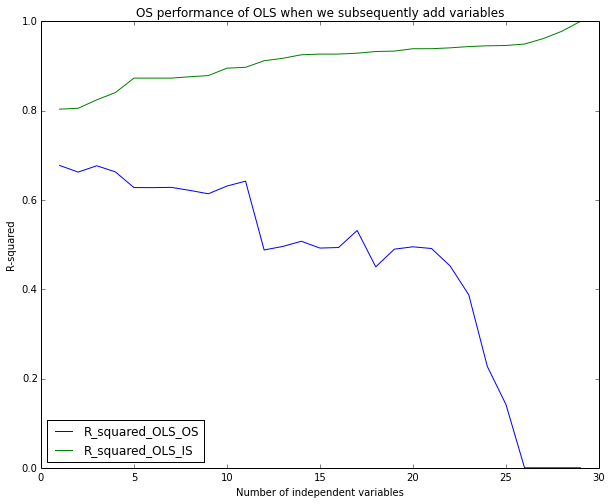

In [17]:
#OS OLS R2 deneding on the number of variables t

Number_variables=[]

OLS_R_2_OS_F=[]
OLS_R_2_IS_F=[]

t=0

##########################################################################################################
##########################################################################################################

for j in range(len(X_train.T)): #subsequently add variables
    
    t+=1
    Number_variables.append(t)

    result=ols(y=y_train,x=pd.DataFrame(X_train[:,0:j+1]))
    temp=X_test[:,0:j+1]

    a=np.array(temp)
    b=np.array(result.beta)
    c=np.sum(a*b[0:-1],axis=1)+b[-1]

    error=y_test-c
    R_2=1-error.var()/y_test.var()
    if R_2>0:
        OLS_R_2_OS_F.append(R_2)
    else:
        OLS_R_2_OS_F.append(0)
    
    OLS_R_2_IS_F.append(result.r2)

pylab.title('OS performance of OLS when we subsequently add variables')
pylab.plot(Number_variables,OLS_R_2_OS_F,'b',label='R_squared_OLS_OS')
pylab.plot(Number_variables,OLS_R_2_IS_F,'g',label='R_squared_OLS_IS')


pylab.legend(loc='lower right')
pylab.xlabel('Number of independent variables')
pylab.ylabel('R-squared')
pylab.legend(loc='lower left')
pylab.show()

As we see OS OLS R2 is pretty different for IS R2 and the difference starts to grow especially rapidly for $t>20$, so there is clearly a major overfitting problem with OLS at that point. Let's see if Lasso/Ridge are able to fix this issue.

In [18]:
Ridge=linear_model.Ridge(fit_intercept=True,alpha=1) #try Ridge with an arbitrary regularization parameter lambda=1

Ridge.fit(X_train,y_train)
# In the sample:
p_IS=Ridge.predict(X_train)
err_IS=p_IS-y_train
R_2_IS_Ridge=1-np.var(err_IS)/np.var(y_train)
print("The R-squared we found for IS Ridge is: {0}".format(R_2_IS_Ridge))

Ridge_coef=Ridge.coef_
############################################################################    
    
#Out of sample
p_OS=Ridge.predict(X_test)
err_OS=p_OS-y_test
R_2_OS_Ridge=1-np.var(err_OS)/np.var(y_test)
print("The R-squared we found for OS Ridge is: {0}".format(R_2_OS_Ridge))

The R-squared we found for IS Ridge is: 0.835638878661
The R-squared we found for OS Ridge is: 0.615809865692


So even with a pretty arbitrary choice of lambda Ridge works pretty well, mostly fixing the overfitting issue. Let's see if one can do better with a more sophisticated choice - for that purpose further split the former training set into training and validation, so that for each lambda the model is being trained over the smaller training sample and optimal lambda is selected based on the model performance over the validation set. Then final result is evaluated over the test set as before.

In [19]:
#Find the Alpha and report best test performance for Ridge/Lasso.
def Regularization_fit_lambda(model,X_train,y_train,lambdas,p=0.4,Graph=False, logl=False):
    
    #model=1 -Ridge, 2-Lasso
    #X_train, y_train is training set
    #lambdas: a list of lambda values to try
    #p: ratio of the validation sample size/ total training size
    #Graph: plot the graph of R^2 values for different lambda
##############################################################################################################################    
    
    rnd.seed(2014)
    R_2_OS=[] #make a list to store R-squared. We need in end to pick the lambda having the biggest R2.
    
    validation_index=rnd.sample(list(range(len(X_train))),int(len(X_train)*p) ) #choose some rows for the validation sample    
    training_index=[x for x in list(range(len(X_train))) if x not in validation_index] # Use the rest of rows as a training sample
    
    
    X_validation=X_train[validation_index,:]
    y_validation=y_train[validation_index]

    X_train0=X_train[training_index,:]
    y_train0=y_train[training_index]
    
    
    for a in lambdas:
        if model==1:
            RM=linear_model.Ridge(fit_intercept=True, alpha=a)
            model_label='Ridge'
        else:
            RM=linear_model.Lasso(fit_intercept=True, alpha=a)
            model_label='Lasso'
        RM.fit(X_train0,y_train0)  #fit the regularization model
        
        y_predict=RM.predict(X_validation) #compute the prediction for the validation sample 
        err_OS=y_predict-y_validation
        R_2_OS_=1-np.var(err_OS)/np.var(y_validation)
        R_2_OS.append(R_2_OS_)
    
#Find the alpha that c.r.t the biggest R^2
    best_R2 = max(R_2_OS)
    for i in range(len(R_2_OS)):
        if R_2_OS[i]==best_R2:
            best_lambda=lambdas[i]
    #print("The alpha we found for Ridge is:{0}".format(l))
    
    #Graph
    if Graph==True:
        pylab.title('IS R-squared vs OS-R-squared for different Lambda')
        if logl:
            pylab.xlabel('ln(Lambda)')
            l=log(lambdas)
            bl=log(best_lambda)
        else:
            pylab.xlabel('Lambda')
            l=lambdas
            bl=best_lambda
        pylab.plot(l,R_2_OS,'b',label=model_label)
        pylab.legend(loc='upper right')
        pylab.ylabel('R-squared')
        pylab.axvline(bl,color='r',linestyle='--')

        pylab.show()
    
    return best_lambda

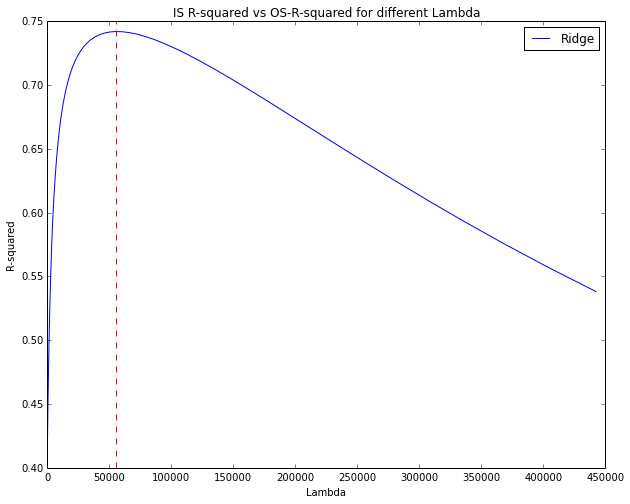

Optimal lambda for Ridge=55248.5839921


In [20]:
#select best lambda for Ridge
lambdas = np.linspace(-5,13,200)
lambdas=[math.exp(i) for i in lambdas]
lambda_r_optimal=Regularization_fit_lambda(1,X_train,y_train,lambdas,p=0.4,Graph=True)
print('Optimal lambda for Ridge={0}'.format(lambda_r_optimal))

In [21]:
Ridge=linear_model.Ridge(fit_intercept=True,alpha=lambda_r_optimal) #try Ridge with a selected regularization parameter lambda

Ridge.fit(X_train,y_train)
# In the sample:
p_IS=Ridge.predict(X_train)
err_IS=p_IS-y_train
R_2_IS_Ridge=1-np.var(err_IS)/np.var(y_train)
print("The R-squared we found for IS Ridge is: {0}".format(R_2_IS_Ridge))

Ridge_coef=Ridge.coef_
############################################################################    
    
#Out of sample
p_OS=Ridge.predict(X_test)
err_OS=p_OS-y_test
R_2_OS_Ridge=1-np.var(err_OS)/np.var(y_test)
print("The R-squared we found for OS Ridge is: {0}".format(R_2_OS_Ridge))

The R-squared we found for IS Ridge is: 0.815602153898
The R-squared we found for OS Ridge is: 0.632932481545


In [22]:
Ridge_coef

array([ 0.02517172,  0.02218572,  0.00809009,  0.00752659, -0.01231968,
        0.00537877,  0.04359522,  0.02349467,  0.04563726,  0.00765238,
       -0.01838121,  0.00980197, -0.03850794, -0.00288114, -0.00891382,
        0.02357866, -0.00111899, -0.0097049 , -0.04449715,  0.00775819,
        0.03536851, -0.00568311,  0.0124728 , -0.00536527, -0.01624446,
       -0.00551884,  0.01745864, -0.0198678 ,  0.00324518])

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


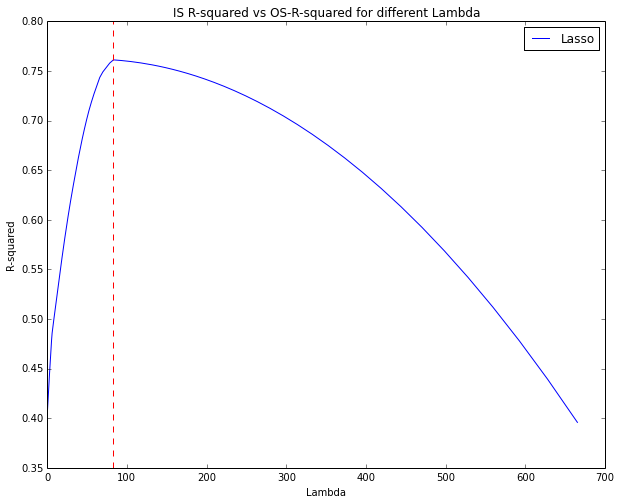

Optimal lambda for Lasso=83.0628865303


In [23]:
#select lambdas for Lasso
lambdas = np.linspace(-5,6.5,200)
lambdas=[math.exp(i) for i in lambdas]
lambda_l_optimal=Regularization_fit_lambda(2,X_train,y_train,lambdas,p=0.4,Graph=True)
print('Optimal lambda for Lasso={0}'.format(lambda_l_optimal))

In [24]:
Lasso=linear_model.Lasso(fit_intercept=True,alpha=lambda_l_optimal) #try Ridge with a selected regularization parameter lambda

Lasso.fit(X_train,y_train)
# In the sample:
p_IS=Lasso.predict(X_train)
err_IS=p_IS-y_train
R_2_IS_Lasso=1-np.var(err_IS)/np.var(y_train)
print("The R-squared we found for IS Lasso is: {0}".format(R_2_IS_Ridge))

Lasso_coef=Lasso.coef_
############################################################################    
    
#Out of sample
p_OS=Lasso.predict(X_test)
err_OS=p_OS-y_test
R_2_OS_Lasso=1-np.var(err_OS)/np.var(y_test)
print("The R-squared we found for OS Lasso is: {0}".format(R_2_OS_Lasso))

The R-squared we found for IS Lasso is: 0.815602153898
The R-squared we found for OS Lasso is: 0.652257395852


In [25]:
Lasso_coef

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.26033553,  0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        ])

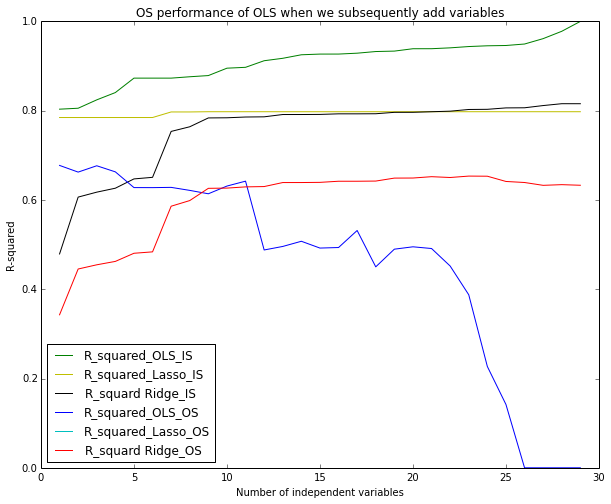

In [26]:
#OS OLS R2 deneding on the number of variables t

Number_variables=[]

OLS_R_2_OS_F=[]
OLS_R_2_IS_F=[]
OLS_R_2_Ridge_OS_F=[]
OLS_R_2_Ridge_IS_F=[]
OLS_R_2_Lasso_OS_F=[]
OLS_R_2_Lasso_IS_F=[]

t=0

##########################################################################################################
##########################################################################################################

for j in range(len(X_train.T)): #subsequently add variables
    
    t+=1
    Number_variables.append(t)

    #For OLS

    result=ols(y=y_train,x=pd.DataFrame(X_train[:,0:j+1]))
    temp=X_test[:,0:j+1]

    a=np.array(temp)
    b=np.array(result.beta)
    c=np.sum(a*b[0:-1],axis=1)+b[-1]

    error=y_test-c
    R_2_OS_OLS=1-error.var()/y_test.var()
    if R_2_OS_OLS>0:
        OLS_R_2_OS_F.append(R_2_OS_OLS)
    else:
        OLS_R_2_OS_F.append(0)
    
    R_2_IS_OLS=result.r2
    OLS_R_2_IS_F.append(R_2_IS_OLS)
    
    
    #For Ridge

    
    Ridge=linear_model.Ridge(fit_intercept=True,alpha=lambda_r_optimal)
    Ridge.fit(X_train[:,0:j+1],y_train)
    
    # In the sample:
    p_IS=Ridge.predict(X_train[:,0:j+1])
    err_IS=p_IS-y_train
    R_2_IS_Ridge=1-np.var(err_IS)/np.var(y_train)
    OLS_R_2_Ridge_IS_F.append(R_2_IS_Ridge)
    
    #Out of sample
    p_OS=Ridge.predict(X_test[:,0:j+1])
    err_OS=p_OS-y_test
    R_2_OS_Ridge=1-np.var(err_OS)/np.var(y_test)
    
    if R_2_OS_Ridge>0:
        OLS_R_2_Ridge_OS_F.append(R_2_OS_Ridge)
    else:
        OLS_R_2_Ridge_OS_F.append(0)
    

#For Lasso
    Lasso=linear_model.Lasso(fit_intercept=True, alpha=lambda_l_optimal)
    Lasso.fit(X_train[:,0:j+1],y_train)
    
    #In the sample:
    p_IS=Lasso.predict(X_train[:,0:j+1])
    err_IS=p_IS-y_train
    R_2_IS_Lasso=1-np.var(err_IS)/np.var(y_train)
    OLS_R_2_Lasso_IS_F.append(R_2_IS_Lasso)
  
 ###########################################################################    

    #Out of sample
    p_OS=Lasso.predict(X_test[:,0:j+1])
    err_OS=p_OS-y_test
    R_2_OS_Lasso=1-np.var(err_OS)/np.var(y_test)
    if R_2_OS>0:
        OLS_R_2_Lasso_OS_F.append(R_2_OS_Lasso)
    else:
        OLS_R_2_Lasso_OS_F.append(0)

pylab.title('OS performance of OLS when we subsequently add variables')

pylab.plot(Number_variables,OLS_R_2_IS_F,'g',label='R_squared_OLS_IS')
pylab.plot(Number_variables,OLS_R_2_Lasso_IS_F,'y',label='R_squared_Lasso_IS')
pylab.plot(Number_variables,OLS_R_2_Ridge_IS_F,'k',label='R_squard Ridge_IS')

pylab.plot(Number_variables,OLS_R_2_OS_F,'b',label='R_squared_OLS_OS')
pylab.plot(Number_variables,OLS_R_2_Lasso_OS_F,'c',label='R_squared_Lasso_OS')
pylab.plot(Number_variables,OLS_R_2_Ridge_OS_F,'r',label='R_squard Ridge_OS')

pylab.legend(loc='lower right')
pylab.xlabel('Number of independent variables')
pylab.ylabel('R-squared')
pylab.legend(loc='lower left')
pylab.show()

In [27]:
#let's look at the final coefficients
name=["var_{0}".format(i+1) for i in range(len(OLS_coef)-1)] # Generate name of rows/variables

result=[name, np.ndarray.tolist(np.asarray(OLS_coef[0:len(OLS_coef)-1])),np.ndarray.tolist(Ridge_coef),
        np.ndarray.tolist(Lasso_coef)] # put all the estimations of different models together(it is same for OS and IS)
temp=pd.DataFrame(result).T
R2_IS=pd.DataFrame(['R2_IS',R_2_IS_OLS, R_2_IS_Ridge,R_2_IS_Lasso]).T # paste the In sample R2 in the end of temp
R2_OS=pd.DataFrame(['R2_OS',R_2_OS_OLS, R_2_OS_Ridge,R_2_OS_Lasso]).T # paste the Out of sample R2 in the end of temp

temp=temp.append(R2_IS)
result=temp.append(R2_OS)
result.columns=['','OLS','Ridge','Lasso'] # Change the column name
result.set_index('')

,OLS,Ridge,Lasso
,,,
var_1,2.965364e+10,0.02517172,0
var_2,1.44002e+10,0.02218572,0
var_3,-2.312817e+10,0.008090091,0
var_4,-9.130204e+09,0.007526593,0
var_5,-1.411581e+10,-0.01231968,-0
var_6,1.152954e+10,0.005378767,0
var_7,1.308259e+09,0.04359522,0
var_8,-5.533222e+09,0.02349467,0
var_9,-1.428208e+09,0.04563726,0.2603355


#### Problem 1. Cross-validation. 
Certainly on such a small sample performance might largely depend on the split between training, validation and test sets. In order to verify that efficiency of Lasso and Ridge is not just a random consequence of a favorable split perform a cross-validation, reporting average IS/OS performance for each model averaged over 10 different random splits.

# Example 4. Predicting real-estate prices using location parameters

Before we tried to use some parameters of the house (size) to predict its price. However notice that location matters as well. Below we upload a sample (approximately 30% of the total) of more than 2000 individual house sales all around NYC in 2012. Each record together with the parameters of the house also contains important characteristics of the location (zip code) - average income of its residents (accodring to US census), as well as the relative structure of 311 complains happening in the area.

In [28]:
#load the data
data4=pd.read_csv("data/example4.csv", low_memory=False)

In [29]:
data4.head()

,Unnamed: 0,Unnamed: 0.1,borough,neighborhood,building_class_category,tax_class_present,block,lot,easement,building_class_present,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X Ray Machine Equipment
0,0,0,4,COLLEGE POINT,01 ONE FAMILY HOMES,1,3937,31,NaN,A9,...,0.000000,0.000000,0.000000,0.001797,0.001540,0.003850,0.002053,0.049281,0,0
1,1,1,1,MIDTOWN EAST,01 ONE FAMILY HOMES,1,1322,18,NaN,A4,...,0.000227,0.000227,0.000000,0.010675,0.000454,0.001817,0.000227,0.050874,0,0
2,2,2,4,SPRINGFIELD GARDENS,01 ONE FAMILY HOMES,1,13029,24,NaN,A1,...,0.000000,0.000000,0.004484,0.000000,0.000179,0.007354,0.001256,0.069058,0,0
3,3,3,3,CROWN HEIGHTS,01 ONE FAMILY HOMES,1,1222,53,NaN,A4,...,0.000170,0.000170,0.000908,0.000568,0.000170,0.000454,0.000341,0.012433,0,0
4,4,4,3,CYPRESS HILLS,01 ONE FAMILY HOMES,1,3919,4,NaN,A5,...,0.000491,0.000197,0.005897,0.000590,0.000393,0.001622,0.000442,0.037445,0,0


In [30]:
# Run OLS
y=data4['sale_price']
X=data4['gross_sq_feet']
result=ols(y=y,x=X)
print(" The R-Squared of this model is:")
print(result.r2)
result.summary_as_matrix.T

 The R-Squared of this model is:
0.329693239244


,beta,p-value,std err,t-stat
x,900.468193,2.130323e-208,26.357322,34.163872
intercept,-1011268.432499,1.885970e-74,53457.538558,-18.917228


Even with the intercept, R2 is not too high - perhaps because of the spatial heterogeniety of the pricing. Let's see if this could be improved by considering other properties of the location but first move to the log scale as the properties of the location are likely to have multiplicative rather than additive impact on the price.

In [31]:
#Take logs of our variabes and repeat the regression
data4['sale_price_log']=np.log(data4['sale_price']).round(decimals=3)
data4['gross_sq_feet_log']=np.log(data4['gross_sq_feet']).round(decimals=3)
y=data4['sale_price_log']
X=data4['gross_sq_feet_log']
result=ols(y=y,x=X)
print(" The R-Squared of this model is:")
print(result.r2)
result.summary_as_matrix.T

 The R-Squared of this model is:
0.295837837416


,beta,p-value,std err,t-stat
x,0.992956,5.519823e-183,0.031448,31.574711
intercept,5.622858,1.502389e-114,0.233807,24.049125


This regression is actually a power-law non-linear model already. No surprize that the slope coefficient for the log of house size is close to 1 with a very narrow confidence interval - one would expect to have the price of the house to be in the approximately linear proportion to its size 

Now try adding a first characteristic of the location - average income (also on the log scale)

In [32]:
#Take logs of our variabes and repeat the regression
data4['mean_log']=np.log(data4['mean']).round(decimals=3)
y=data4['sale_price_log']
X=data4[['mean_log','gross_sq_feet_log']]
result=ols(y=y,x=X)
print(" The R-Squared of this model is:")
print(result.r2)
result.summary_as_matrix.T

 The R-Squared of this model is:
0.344496603562


,beta,p-value,std err,t-stat
mean_log,0.505073,8.132877e-39,0.038063,13.269373
gross_sq_feet_log,0.928775,5.063411e-170,0.030731,30.222480
intercept,0.441324,3.278924e-01,0.450989,0.978570


The model fit is slightly improved and it seems that the price is proportional to the square root of the location wealth. Although wealth is important it seems it does not tell the whole story as 30% R2 is still not too high. Let's see if the patterns of people complains tell more relevant infromation about the context of the location.

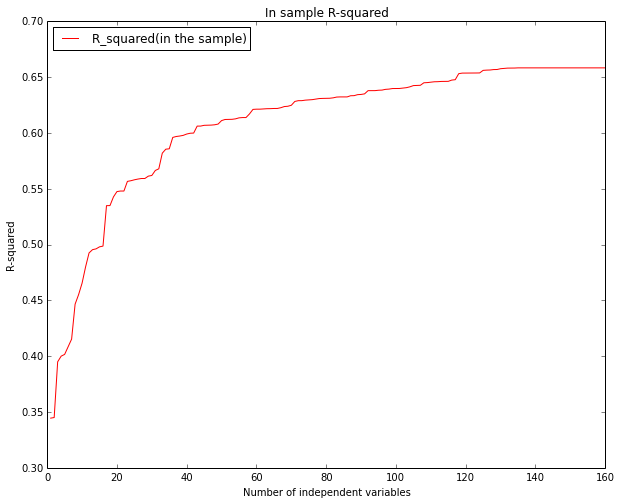

In [33]:
# Track the model performance while we add more 311-related variables (R2 vs the number of variables t)
list_comp=data4.columns[data4.columns.get_loc("Adopt A Basket"):data4.columns.get_loc("X Ray Machine Equipment")+1]
list_comp=list(list_comp.values.tolist())

#In the sample test
Number_variables_L=[]
OLS_R_2_L=[]
depend_variable_L=['mean_log']
t=0
# Do it for more dependent variables from 311
for j in (['gross_sq_feet_log']+[list_comp[i] for i in range(len(list_comp))]):
    
    t=t+1
    Number_variables_L.append(t)
    depend_variable_L.append(j)
    X=data4[depend_variable_L]
    y=data4['sale_price_log']
    result=ols(y=y,x=X)
    OLS_R_2_L.append(result.r2)
    
#####################################################################################

pylab.title('In sample R-squared')
pylab.plot(Number_variables_L,OLS_R_2_L,'r',label='R_squared(in the sample)')
pylab.legend(loc='upper left')
pylab.xlabel('Number of independent variables')
pylab.ylabel('R-squared')
pylab.show()



So looks like the new variables did a perfect job rising R2 to 65%! But is the model generalizeable or do we simply overfit? In order to test that let's split the data into the separate training and test set and re-run the model.

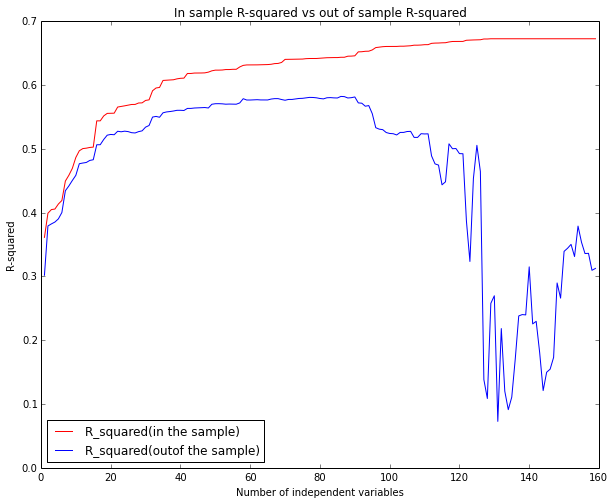

In [34]:
var=len(list_comp)

# p= training sample size/ total sample size

p=0.7 # we use 70% data for training and 30% data for prediction.

#####################################################################################################################################
# Split data by p

X=data4

#train_index=random.sample(list(range(len(X))),int(len(X)*p))

#####################################################################################################################################
#For the example just fix one of the splits
a=[616, 2364, 2064, 1098, 726, 1866, 1649, 18, 1927, 69, 1264, 1224, 1001, 2034, 1214, 444, 1665, 53, 85, 617, 744, 1707, 1399, 285, 1887, 96, 1861, 1121, 2247, 857, 287, 1869, 1819, 2198, 2161, 507, 309, 88, 784, 1382, 1340, 1668, 1291, 48, 299, 2307, 2049, 646, 719, 1524, 1115, 581, 1502, 2116, 445, 100, 2234, 706, 955, 434, 1614, 2368, 505, 298, 2355, 2133, 185, 341, 737, 1599, 624, 2264, 1182, 519, 1669, 632, 2313, 1755, 461, 1536, 1728, 729, 111, 728, 442, 1075, 884, 1085, 1225, 2294, 297, 1375, 66, 2303, 83, 433, 890, 2259, 1706, 864, 2358, 1908, 970, 1421, 337, 2360, 267, 295, 2104, 1829, 1298, 1547, 191, 991, 1565, 585, 1074, 1270, 995, 1329, 1423, 1667, 1681, 157, 252, 1207, 1549, 40, 983, 177, 975, 972, 684, 1337, 1231, 1124, 1655, 1682, 273, 1359, 1641, 1371, 1806, 1513, 220, 1436, 1874, 555, 2192, 2216, 763, 1317, 87, 1218, 1188, 1751, 324, 1489, 1301, 79, 985, 2086, 1281, 1888, 179, 1997, 1174, 1515, 1252, 1240, 283, 380, 2105, 1942, 1753, 428, 381, 667, 190, 1817, 690, 1361, 1936, 2332, 1746, 939, 2310, 1875, 543, 740, 548, 1160, 1413, 2299, 1602, 2370, 2012, 392, 794, 1999, 495, 1613, 2180, 478, 732, 1760, 1787, 259, 936, 820, 1770, 497, 2329, 2280, 964, 1537, 1801, 1247, 1656, 685, 1930, 2031, 1661, 1675, 1553, 151, 2203, 2125, 2162, 1130, 1860, 1500, 2124, 2320, 1122, 2160, 1117, 800, 1447, 1945, 121, 1870, 2330, 1487, 188, 859, 1333, 1420, 1315, 1815, 1216, 1802, 272, 1961, 1415, 547, 2150, 1617, 2221, 2070, 1400, 789, 1653, 1494, 889, 1876, 1467, 1254, 1147, 1848, 775, 1127, 1699, 2213, 2246, 1858, 1398, 477, 1544, 42, 1282, 496, 1872, 168, 2107, 300, 1307, 1523, 1027, 946, 1955, 1468, 541, 1652, 382, 2036, 662, 827, 1984, 780, 161, 1776, 638, 611, 1525, 793, 2139, 1140, 1320, 1455, 1953, 2151, 86, 1634, 1671, 743, 464, 856, 1163, 399, 395, 413, 2015, 313, 90, 1062, 2148, 388, 1280, 1685, 2334, 2369, 1491, 1080, 348, 928, 1412, 500, 1079, 181, 117, 1103, 761, 2352, 2009, 1227, 1131, 2188, 1272, 449, 672, 1049, 516, 2095, 2229, 1604, 1434, 102, 826, 212, 430, 1128, 318, 2082, 1007, 2025, 1825, 296, 676, 2220, 1938, 94, 373, 1139, 1198, 1883, 1910, 1636, 935, 2163, 465, 1003, 2367, 405, 896, 205, 2242, 1081, 1792, 2142, 1847, 1292, 415, 1120, 1892, 661, 1099, 1909, 1054, 1623, 1208, 2018, 2020, 1167, 1917, 391, 1985, 331, 749, 379, 796, 1732, 879, 881, 1522, 1265, 422, 1406, 319, 81, 1974, 223, 226, 1968, 1711, 2182, 467, 1228, 1601, 974, 1810, 1429, 1657, 71, 1768, 734, 1284, 1411, 339, 1342, 573, 2208, 1804, 2113, 814, 261, 1066, 851, 1737, 2173, 920, 276, 659, 862, 84, 2248, 1519, 839, 1, 1716, 776, 1465, 1477, 1508, 664, 1626, 506, 556, 1492, 2021, 1237, 125, 1625, 193, 215, 182, 60, 2201, 2051, 630, 2103, 786, 2271, 765, 944, 375, 911, 960, 1046, 2235, 1919, 340, 1246, 932, 2014, 229, 2100, 311, 1067, 2187, 986, 425, 610, 1637, 365, 251, 1748, 472, 992, 256, 822, 502, 824, 67, 1507, 1590, 1725, 1034, 1995, 651, 2273, 643, 1493, 1470, 370, 637, 779, 1924, 2285, 2065, 933, 2096, 1934, 2288, 2033, 2184, 948, 70, 95, 58, 2304, 1624, 2236, 1426, 266, 2109, 612, 1136, 1606, 709, 590, 823, 2146, 1578, 1956, 1616, 1569, 25, 756, 751, 1798, 818, 1586, 284, 351, 1784, 806, 1698, 2090, 1232, 1379, 288, 1192, 2054, 1381, 1922, 2069, 93, 1680, 376, 1369, 2152, 1233, 1155, 486, 1212, 362, 1509, 1539, 2275, 1505, 1777, 44, 1990, 1980, 343, 1797, 1731, 679, 322, 1773, 1324, 792, 666, 2177, 2145, 1168, 148, 80, 627, 498, 1552, 280, 1437, 644, 602, 1952, 521, 140, 2004, 183, 320, 1253, 357, 1794, 943, 1622, 1643, 1905, 1071, 2067, 2119, 1821, 746, 1295, 886, 1842, 2174, 1450, 2200, 2005, 957, 162, 1015, 1558, 1205, 2011, 353, 305, 769, 1738, 1309, 623, 2140, 1764, 981, 126, 1365, 1262, 1289, 1763, 927, 201, 1618, 635, 2042, 1377, 1989, 2361, 130, 1805, 535, 598, 1360, 1057, 1608, 990, 907, 2144, 209, 591, 312, 78, 327, 1551, 1169, 1664, 1563, 55, 1918, 14, 565, 1030, 673, 563, 1611, 426, 1631, 1220, 575, 1417, 2157, 1101, 1407, 2309, 1016, 969, 1937, 2322, 1261, 237, 338, 1988, 1780, 2336, 1323, 1314, 403, 870, 314, 526, 2063, 1458, 1195, 367, 1851, 361, 2227, 371, 1568, 1572, 1137, 1654, 439, 1564, 345, 588, 2232, 2183, 514, 938, 1061, 141, 160, 1704, 2204, 1931, 1644, 1761, 511, 423, 115, 211, 924, 1389, 1683, 1257, 1238, 291, 1589, 1148, 1735, 2345, 1827, 993, 783, 198, 1852, 1215, 1069, 1841, 1499, 1296, 1901, 7, 173, 925, 1868, 1402, 2347, 1091, 1351, 239, 186, 2351, 544, 2176, 1718, 2193, 1395, 315, 596, 1367, 1528, 1339, 594, 1650, 605, 1459, 1793, 1812, 1935, 1891, 2306, 1674, 1325, 710, 2072, 1322, 2308, 1702, 289, 968, 1312, 1774, 2269, 725, 1445, 2073, 1579, 1534, 1963, 1973, 171, 1345, 2270, 97, 1592, 199, 1236, 230, 1496, 680, 2262, 1111, 967, 2057, 1279, 2277, 508, 1454, 904, 1779, 34, 694, 1574, 1348, 2219, 1442, 192, 2048, 858, 2350, 265, 59, 852, 1837, 2108, 1757, 1660, 1554, 2071, 1355, 642, 2038, 1330, 705, 1697, 1778, 1879, 649, 1639, 2314, 817, 771, 768, 1178, 203, 2022, 124, 1818, 554, 166, 669, 1230, 1724, 953, 2316, 1977, 1789, 965, 258, 801, 754, 2030, 47, 1191, 404, 2365, 875, 1520, 2156, 530, 1488, 882, 387, 532, 1567, 136, 1078, 1439, 1204, 1146, 586, 33, 562, 354, 522, 727, 1734, 762, 1913, 1308, 24, 892, 488, 269, 56, 1878, 1479, 175, 1024, 1692, 626, 1824, 1332, 1475, 1328, 2083, 1729, 700, 815, 517, 180, 492, 1144, 213, 696, 922, 941, 17, 523, 621, 2121, 663, 2357, 2293, 417, 23, 243, 1021, 2267, 217, 154, 2356, 2325, 26, 1302, 1185, 2023, 326, 1032, 424, 2274, 1052, 1820, 2279, 2359, 2199, 2158, 2348, 2196, 1409, 2055, 369, 1304, 1864, 2029, 494, 1979, 268, 1826, 12, 2167, 2237, 1347, 235, 1431, 574, 1865, 567, 809, 290, 214, 457, 1433, 1064, 254, 1453, 402, 2212, 1752, 463, 741, 43, 738, 1176, 2027, 2249, 1605, 1809, 1326, 966, 108, 187, 2078, 1338, 717, 144, 1882, 1939, 120, 1435, 62, 2250, 1106, 914, 436, 38, 2075, 2300, 360, 2265, 600, 843, 831, 2190, 866, 1278, 1019, 1849, 2040, 480, 1456, 1972, 400, 2058, 670, 1408, 19, 2132, 37, 1267, 2231, 1388, 641, 1229, 958, 227, 959, 482, 1966, 926, 2, 2339, 210, 613, 1762, 349, 1473, 515, 2205, 165, 552, 1384, 1533, 1033, 1571, 570, 2289, 529, 189, 1719, 2019, 675, 1383, 1495, 233, 1463, 21, 1142, 2331, 1401, 328, 1331, 419, 308, 634, 1744, 325, 853, 533, 248, 1987, 1679, 945, 279, 639, 1800, 1890, 524, 545, 1440, 1343, 1275, 2282, 1076, 1094, 2298, 1978, 1143, 869, 698, 307, 1154, 1486, 1020, 1584, 905, 2143, 897, 1678, 2362, 2010, 1045, 386, 1814, 833, 1766, 432, 1416, 1898, 1100, 1630, 1072, 323, 1153, 891, 609, 1585, 665, 355, 1722, 2175, 147, 2214, 877, 2255, 781, 1422, 390, 1438, 1928, 686, 1095, 1242, 1480, 1853, 350, 668, 454, 546, 1562, 1083, 219, 636, 1511, 1673, 1180, 169, 722, 1427, 127, 329, 489, 810, 207, 206, 2059, 982, 802, 1709, 1035, 1060, 394, 1217, 2172, 470, 2302, 902, 99, 640, 2093, 1336, 358, 366, 1352, 2189, 1600, 2253, 156, 693, 597, 1134, 2263, 980, 1896, 1529, 2043, 2159, 255, 1929, 1104, 1832, 1464, 1873, 2002, 1047, 1368, 607, 1397, 2186, 528, 200, 476, 1023, 401, 1686, 202, 1867, 1967, 484, 1138, 1460, 854, 1028, 619, 961, 1958, 77, 50, 2290, 2281, 1715, 344, 901, 629, 1976, 1526, 1521, 2165, 347, 332, 865, 1689, 1951, 1376, 2080, 1044, 1886, 2007, 797, 1739, 671, 1363, 1555, 1183, 409, 799, 1628, 531, 1089, 942, 1449, 1335, 795, 622, 2323, 164, 1897, 238, 984, 1831, 861, 2123, 204, 509, 1184, 167, 2138, 1073, 2268, 82, 872, 1025, 234, 1531, 829, 1485, 2130, 2226, 1700, 2062, 208, 1065, 1740, 1132, 954, 112, 702, 1165, 1803, 1807, 1223, 952, 2118, 592, 579, 1741, 1425, 2111, 253, 1211, 1392, 918, 2238, 2366, 1201, 910, 1844, 1171, 1850, 2245, 2258, 195, 504, 1039, 1251, 150, 1444, 1705, 359, 2041, 1471, 739, 647, 119, 224, 1540, 2287, 1287, 146, 1941, 6, 840, 2099, 1288, 1998, 2087, 2251, 2254, 2050, 2006, 540, 1014, 1114, 977, 1932, 733, 2321, 336, 1687, 1018, 1629, 1159, 466, 1164, 1206, 1259, 1394, 1290, 1474, 1266, 1912, 819, 2074, 1151, 745, 1226, 1187, 2106, 1855, 1173, 876, 2363, 91, 1469, 1037, 2147, 1621, 2278, 2374, 1498, 1077, 29, 973, 1109, 1696, 1084, 841, 2286, 363, 222, 1380, 231, 1996, 2218, 109, 1102, 1717, 1349, 1248, 1642, 595, 374, 512, 2194, 1583, 1481, 1446, 1991, 701, 455, 1405, 1478, 1662, 262, 1720, 583, 1900, 1203, 1209, 1786, 499, 1672, 513, 569, 2195, 396, 1758, 1516, 1055, 2000, 1570, 158, 2343, 1344, 293, 2305, 1327, 2155, 913, 572, 899, 1087, 2272, 393, 1726, 1712, 1276, 420, 1648, 812, 73, 2211, 956, 1196, 1441, 1403, 2297, 759, 116, 52, 887, 196, 1145, 1839, 1620, 1981, 2354, 2223, 1581, 1933, 2081, 1527, 1670, 1050, 1056, 2068, 36, 1108, 525, 246, 2349, 473, 1414, 1983, 1294, 1663, 2338, 618, 277, 1009, 1743, 873, 919, 1538, 1863, 1947, 798, 1273, 228, 951, 1386, 587, 2197, 2335, 128, 1362, 1358, 2149, 2319, 963, 364, 653, 1031, 1017, 1150, 681, 2283, 1105, 1258, 1306, 1506, 471, 194, 1658, 561, 518, 1799, 356, 1036, 2052, 601, 688, 1862, 389, 1149, 838, 264, 1916, 1022, 735, 1213, 435, 772, 2102, 950, 1472, 787, 714, 4, 699, 406, 1745, 1006, 2207, 832, 895, 1448, 846, 1830, 1366, 274, 2333, 1286, 1607, 1255, 708, 1378, 1181, 1902, 1113, 218, 174, 1693, 68, 1357, 1038, 804, 1311, 628, 138, 1594, 2225, 485, 139, 689, 1795, 1222, 847, 848, 912, 1186, 1451, 57, 1894, 1256, 1684, 2341, 304, 1749, 1576, 542, 469, 2115, 1597, 645, 1396, 1911, 2101, 1158, 410, 987, 453, 510, 606, 1845, 2091, 1647, 346, 2233]
train_index=a
test_index=[x for x in list(range(len(X))) if x not in train_index]
####################################################################################################################################

#Data for training
data_train=data4.iloc[train_index]
#Data for predicting
data_test=data4.iloc[test_index]

#In the sample test
Number_variables=[]
OLS_R_2_IS=[] # make a list to store our in the sample R_squared
OLS_R_2_OS=[] #make a list to store our out the sample R_squared
depend_variable=['mean_log','gross_sq_feet_log']
t=0

# Do a loop to run OLS after adding additional independent variables from 311 subsequently
for j in ([list_comp[i] for i in range(var)]):

    t+=1
    Number_variables.append(t)

    depend_variable.append(j)
    X=data_train[depend_variable]
    y=data_train['sale_price_log']
    result=ols(y=y,x=X)
    OLS_R_2_IS.append(result.r2)

############################################################################
#Out of the sample test

    temp=data_test[depend_variable]

    a=np.array(temp)
    b=np.array(result.beta)
    c=np.sum(a*b[0:-1],axis=1)+b[-1]

    error=data_test['sale_price_log']-c
    R_2=1-error.var()/data_test['sale_price_log'].var()
    if R_2>0:
        OLS_R_2_OS.append(R_2)
    else:
        OLS_R_2_OS.append(0)

#plot
pylab.title('In sample R-squared vs out of sample R-squared')
pylab.plot(Number_variables,OLS_R_2_IS,'r',label='R_squared(in the sample)')
pylab.plot(Number_variables,OLS_R_2_OS,'b',label='R_squared(outof the sample)')
pylab.legend(loc='lower left')
pylab.xlabel('Number of independent variables')
pylab.ylabel('R-squared')
pylab.draw()



So clearly, the new 311-related regressors add considerable value, however OLS runs into overfitting and start to crash after $t=90$ approximately. Let's see if Ridge and Lasso can fix it

In [35]:
Ridge=linear_model.Ridge(fit_intercept=True,alpha=1) #try Ridge and Lasso with an arbitrary regularization parameter lambda
Lasso=linear_model.Lasso(fit_intercept=True,alpha=1)

X_train=np.matrix(data_train[depend_variable])
y_train=np.array(data_train['sale_price_log'])
X_test=np.matrix(data_test[depend_variable])
y_test=np.array(data_test['sale_price_log'])
Ridge.fit(X_train,y_train)
Lasso.fit(X_train,y_train)
# In the sample:
p_IS=Ridge.predict(X_train)
err_IS=p_IS-y_train
R_2_IS_Ridge=1-np.var(err_IS)/np.var(y_train)

p_IS=Lasso.predict(X_train)
err_IS=p_IS-y_train
R_2_IS_Lasso=1-np.var(err_IS)/np.var(y_train)

Ridge_coef=Ridge.coef_
Lasso_coef=Lasso.coef_
############################################################################    
    
#Out of sample
p_OS=Ridge.predict(X_test)
err_OS=p_OS-y_test
R_2_OS_Ridge=1-np.var(err_OS)/np.var(y_test)

p_OS=Lasso.predict(X_test)
err_OS=p_OS-y_test
R_2_OS_Lasso=1-np.var(err_OS)/np.var(y_test)
print("The R-squared we found for IS Ridge is: {0}".format(R_2_IS_Ridge))
print("The R-squared we found for OS Ridge is: {0}".format(R_2_OS_Ridge))
print("The R-squared we found for IS Lasso is: {0}".format(R_2_IS_Lasso))
print("The R-squared we found for OS Lasso is: {0}".format(R_2_OS_Lasso))

The R-squared we found for IS Ridge is: 0.519823192216
The R-squared we found for OS Ridge is: 0.488450370258
The R-squared we found for IS Lasso is: -2.22044604925e-16
The R-squared we found for OS Lasso is: 0.0


So Ridge works ok even with an arbitrary $\lambda=1$, while for Lasso tuning of the parameter is certainly needed. Let use the previous function to make it for both regularization models

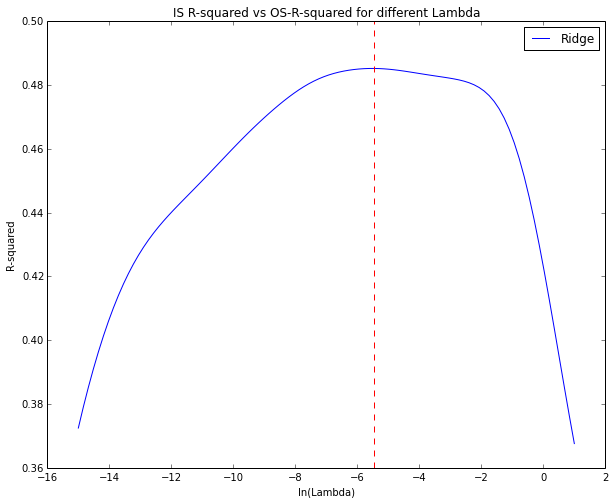

Optimal lambda for Ridge=0.00423383759375


In [36]:
#select best lambda for Ridge
lambdas = np.linspace(-15,1,100)
lambdas=[math.exp(i) for i in lambdas]
lambda_r_optimal=Regularization_fit_lambda(1,X_train,y_train,lambdas,p=0.4,Graph=True,logl=True)
print('Optimal lambda for Ridge={0}'.format(lambda_r_optimal))

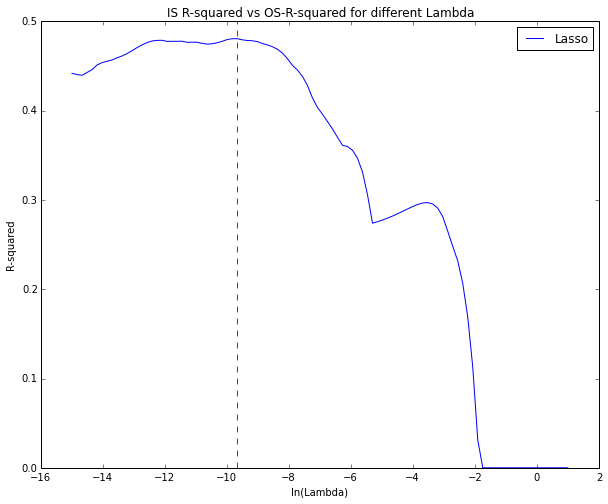

Optimal lambda for Lasso=0.00423383759375


In [37]:
#select best lambda for Lasso
lambdas = np.linspace(-15,1,100)
lambdas=[math.exp(i) for i in lambdas]
lambda_l_optimal=Regularization_fit_lambda(2,X_train,y_train,lambdas,p=0.4,Graph=True,logl=True)
print('Optimal lambda for Lasso={0}'.format(lambda_r_optimal))

In [38]:
Ridge=linear_model.Ridge(fit_intercept=True,alpha=lambda_r_optimal) #redo Ridge and Lasso with selected regularization parameter lambda
Lasso=linear_model.Lasso(fit_intercept=True,alpha=lambda_l_optimal)

X_train=np.matrix(data_train[depend_variable])
y_train=np.array(data_train['sale_price_log'])
X_test=np.matrix(data_test[depend_variable])
y_test=np.array(data_test['sale_price_log'])
Ridge.fit(X_train,y_train)
Lasso.fit(X_train,y_train)
# In the sample:
p_IS=Ridge.predict(X_train)
err_IS=p_IS-y_train
R_2_IS_Ridge=1-np.var(err_IS)/np.var(y_train)

p_IS=Lasso.predict(X_train)
err_IS=p_IS-y_train
R_2_IS_Lasso=1-np.var(err_IS)/np.var(y_train)

Ridge_coef=Ridge.coef_
Lasso_coef=Lasso.coef_
############################################################################    
    
#Out of sample
p_OS=Ridge.predict(X_test)
err_OS=p_OS-y_test
R_2_OS_Ridge=1-np.var(err_OS)/np.var(y_test)

p_OS=Lasso.predict(X_test)
err_OS=p_OS-y_test
R_2_OS_Lasso=1-np.var(err_OS)/np.var(y_test)
print("The R-squared we found for IS Ridge is: {0}".format(R_2_IS_Ridge))
print("The R-squared we found for OS Ridge is: {0}".format(R_2_OS_Ridge))
print("The R-squared we found for IS Lasso is: {0}".format(R_2_IS_Lasso))
print("The R-squared we found for OS Lasso is: {0}".format(R_2_OS_Lasso))

The R-squared we found for IS Ridge is: 0.618653826565
The R-squared we found for OS Ridge is: 0.568764752496
The R-squared we found for IS Lasso is: 0.597422426435
The R-squared we found for OS Lasso is: 0.563935422612


This is much better now - we can see that R2 values are much improved - both Lasso and Ridge provide 56% OS R2. And as IS and OS R2 are close there is almost no oferfitting left - both Lasso and Ridge manage it efficiently. Finally let's reproduce the learning curves - IS/OS R2 depending on t for all three models - OLS, Lasso and Ridge - in order to track the dynamics. 

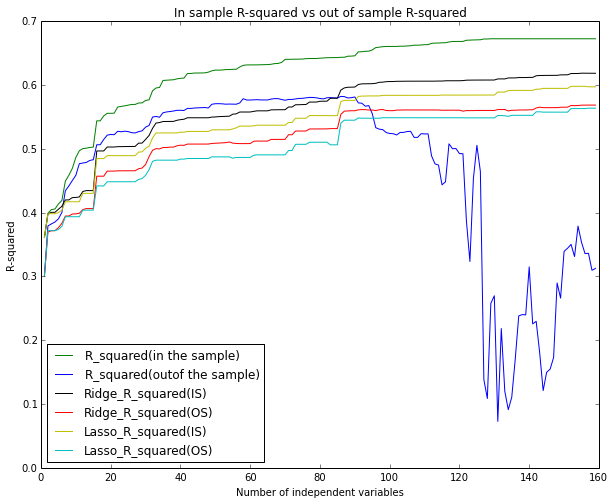

In [39]:
#In the sample test
Number_variables=[]
OLS_R_2_IS=[] # make a list to store our in the sample R_squared
Ridge_R_2_IS=[]
Lasso_R_2_IS=[]
OLS_R_2_OS=[] #make a list to store our out the sample R_squared
Ridge_R_2_OS=[]
Lasso_R_2_OS=[]
depend_variable=['mean_log','gross_sq_feet_log']
t=0

# Do a loop to run OLS after adding additional independent variables from 311 subsequently
for j in ([list_comp[i] for i in range(var)]):

    t+=1
    Number_variables.append(t)

    depend_variable.append(j)
# In the sample:

    X=data_train[depend_variable]
    y=data_train['sale_price_log']
    result=ols(y=y,x=X)
    OLS_R_2_IS.append(result.r2)
    
    X=np.matrix(data_train[depend_variable])
    y=np.array(data_train['sale_price_log'])
    Ridge=linear_model.Ridge(fit_intercept=True,alpha=lambda_r_optimal)
    Lasso=linear_model.Lasso(fit_intercept=True,alpha=lambda_l_optimal)
    Ridge.fit(X,y)
    Lasso.fit(X,y)
    p_IS=Ridge.predict(X)
    err_IS=p_IS-y
    R_2_IS_Ridge=1-np.var(err_IS)/np.var(y)
    p_IS=Lasso.predict(X)
    err_IS=p_IS-y
    R_2_IS_Lasso=1-np.var(err_IS)/np.var(y)
    Ridge_R_2_IS.append(R_2_IS_Ridge)
    Lasso_R_2_IS.append(R_2_IS_Lasso)

############################################################################
#Out of the sample test

    temp=data_test[depend_variable]

    a=np.array(temp)
    b=np.array(result.beta)
    c=np.sum(a*b[0:-1],axis=1)+b[-1]
    
    X_test=np.matrix(data_test[depend_variable])
    y_test=np.array(data_test['sale_price_log'])

    error=data_test['sale_price_log']-c
    R_2=1-error.var()/data_test['sale_price_log'].var()
    if R_2>0:
        OLS_R_2_OS.append(R_2)
    else:
        OLS_R_2_OS.append(0)
        
    p_OS=Ridge.predict(X_test)
    err_OS=p_OS-y_test
    R_2_OS_Ridge=1-np.var(err_OS)/np.var(y_test)

    p_OS=Lasso.predict(X_test)
    err_OS=p_OS-y_test
    R_2_OS_Lasso=1-np.var(err_OS)/np.var(y_test) 
    Ridge_R_2_OS.append(R_2_OS_Ridge)
    Lasso_R_2_OS.append(R_2_OS_Lasso)

#plot
pylab.title('In sample R-squared vs out of sample R-squared')
pylab.plot(Number_variables,OLS_R_2_IS,'g',label='R_squared(in the sample)')
pylab.plot(Number_variables,OLS_R_2_OS,'b',label='R_squared(outof the sample)')
pylab.plot(Number_variables,Ridge_R_2_IS,'k',label='Ridge_R_squared(IS)')
pylab.plot(Number_variables,Ridge_R_2_OS,'r',label='Ridge_R_squared(OS)')
pylab.plot(Number_variables,Lasso_R_2_IS,'y',label='Lasso_R_squared(IS)')
pylab.plot(Number_variables,Lasso_R_2_OS,'c',label='Lasso_R_squared(OS)')
pylab.legend(loc='lower left')
pylab.xlabel('Number of independent variables')
pylab.ylabel('R-squared')
pylab.draw()

So we see that Lasso and Ridge perform perfectly stable and unlike OLS, their OS R2 steadily grows with $t$

Finally look at the coefficients of Lasso performing feature selection for us - most of the coefficients are zero while the non-zero ones indicate the regressors left in the model

In [40]:
Lasso_coef

array([  0.34144248,   0.69046956,  -0.        ,   0.        ,
        -0.        ,  -0.        ,   0.        ,  -0.        ,
         0.        ,  -0.        ,   0.        ,   0.        ,
         0.        ,  -0.5262977 ,   0.        ,   0.        ,
         0.        ,   4.37823538,   0.        ,   0.        ,
        -0.        ,  -0.        ,  -0.        ,  -0.        ,
        -0.        ,  -0.        ,   0.        ,   0.        ,
        -0.        ,   7.28434482,   2.97783897,   0.        ,
         0.67294255,  -4.66543363,  -3.8401933 ,  -0.        ,
         0.        ,   0.        ,  -0.        ,  -0.        ,
         0.        ,  -2.0370214 ,  -0.        ,   7.55328286,
        -0.        ,   0.        ,  -0.        ,  -0.        ,
        -0.        ,  -0.        ,  -0.        ,  -0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.55266874,   0.        ,   3.90614547,   0.        ,
         0.        ,   0.        ,  -0.31984493,   0.  